**Proyecto**

**Integrantes:**
- Javiera Peña
- Ivan montiel
- Josschua Machuca
- Manuel De La Hoz

#Profesora:
- Berioska Contreras Vargas

#Asignatura:
- TEL-252 - Criptografía y Seguridad en la Información

Proyecto :D

In [12]:
import os
import time
import base64
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.hmac import HMAC
import random


In [15]:
#Clases a utilizar

class SensorNode:
    def __init__(self, nwk_skey, app_skey):
        self.nwk_skey = nwk_skey
        self.app_skey = app_skey
        self.frame_counter = 0  # Contador de mensajes enviados
        random.seed()

    def generate_data(self):
        #Simula una medición del sensor de temperatura
        aviso_capacidad = " "
        self.frame_counter += 1
        temperatura = round(random.uniform(0,100),2)  
        return f"Temperatura: {temperatura} °C", self.frame_counter

    def encrypt_data(self, message):
        #Cifra los datos del sensor con AppSKey usando AES-CTR.
        nonce = os.urandom(16)  # Nonce único para cada mensaje
        cipher = Cipher(algorithms.AES(self.app_skey), modes.CTR(nonce))
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(message.encode()) + encryptor.finalize()
        return nonce, ciphertext

    def generate_mic(self, payload):
        #Genera el MIC del mensaje usando NwkSKey.
        hmac = HMAC(self.nwk_skey, hashes.SHA256())
        hmac.update(payload)
        mic = hmac.finalize()[:4]  # Usamos los primeros 4 bytes del HMAC
        return mic

    def send_data(self):
        #Genera un mensaje completo (PHYPayload) con cifrado y MIC.
        message, frame_counter = self.generate_data()
        nonce, encrypted_payload = self.encrypt_data(message)
        payload = b''.join([nonce, encrypted_payload])
        mic = self.generate_mic(payload)
        print(f"[Nodo] Enviando: {message}")
        return payload + mic



#Clase
class Gateway:
    def forward_to_network_server(self, message):
        #Simula la retransmisión del mensaje al servidor de red.
        print("[Gateway] enviando mensaje a Network Server...")
        return message

# Servidor de Red
class NetworkServer:
    def __init__(self, nwk_skey):
        self.nwk_skey = nwk_skey

    def verify_mic(self, payload_with_mic):
        #Verifica el MIC del mensaje.
        payload, mic = payload_with_mic[:-4], payload_with_mic[-4:]
        hmac = HMAC(self.nwk_skey, hashes.SHA256())
        hmac.update(payload)
        expected_mic = hmac.finalize()[:4]
        return mic == expected_mic

    def forward_to_application_server(self, payload_with_mic):
        #Reenvía los datos al servidor de aplicaciones después de verificar el MIC.
        if self.verify_mic(payload_with_mic):
            print("[Network Server] MIC Verificado Reenviando a Application Server...")
            return payload_with_mic[:-4]
        else:
            print("[Network Server] MIC Verificación fallida. Descartando Message.")
            return None

# Servidor de Aplicaciones
class ApplicationServer:
    def __init__(self, app_skey):
        self.app_skey = app_skey

    def decrypt_data(self, payload):
        "#escifra los datos de la aplicación."
        nonce, ciphertext = payload[:16], payload[16:]
        cipher = Cipher(algorithms.AES(self.app_skey), modes.CTR(nonce))
        decryptor = cipher.decryptor()
        plaintext = decryptor.update(ciphertext) + decryptor.finalize()
        return plaintext.decode()

    def process_data(self, payload):
        #rocesa los datos recibidos."
        message = self.decrypt_data(payload)
        print(f"[Application Server] Datos Recibidos {message}")



In [16]:
#Funcion de ataque
class Attacker:
    @staticmethod
    def tamper_with_message(payload_with_mic): #Simula un ataque donde intercepta y modifica el mensaje 
        """Modifica el mensaje cifrado."""
        payload, mic = payload_with_mic[:-4], payload_with_mic[-4:]
        print("[Attacker] Se intercepto el mensaje!")
        tampered_payload = bytearray(payload)
        tampered_payload[16] ^= 1  # Cambia arbitrariamente un byte del ciphertext
        return bytes(tampered_payload) + mic  # Mantiene el MIC original


In [18]:
# Simulación de la Red LoRaWAN

def simulate_lorawan():
    # Inicializar componentes
    sensor = SensorNode(NwkSKey, AppSKey)
    gateway = Gateway()
    network_server = NetworkServer(NwkSKey)
    application_server = ApplicationServer(AppSKey)
    attacker = Attacker()

    for i in range(5):

        print(f"\n[Simulation Step {i}]")
        time.sleep(1)
        i = i+1 

        # Nodo genera y envía datos
        phypayload = sensor.send_data()
        ataque = random.randint(1,4) 

        #print(ataque)
        if(ataque == 3 or ataque == 1): # hay ataque cuando ataque = 3 or 1 
            tampered_payload = attacker.tamper_with_message(phypayload)
            forwarded_payload = gateway.forward_to_network_server(tampered_payload) 
        else: 
            forwarded_payload = gateway.forward_to_network_server(phypayload)

        # Servidor de Red verifica y reenvía
        valid_payload = network_server.forward_to_application_server(forwarded_payload)

        # Servidor de Aplicaciones descifra y procesa
        if valid_payload:
            application_server.process_data(valid_payload)

In [19]:


# Claves compartidas para la simulación
APP_KEY = os.urandom(16)  # AppKey: Clave raíz para derivar AppSKey y NwkSKey
NwkSKey = os.urandom(16)  # Clave para autenticidad (MIC)
AppSKey = os.urandom(16)  # Clave para cifrado de datos (payload)



simulate_lorawan()



[Simulation Step 0]
[Nodo] Enviando: Temperatura: 44.19 °C
[Attacker] Se intercepto el mensaje!
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificación fallida. Descartando Message.

[Simulation Step 1]
[Nodo] Enviando: Temperatura: 23.27 °C
[Attacker] Se intercepto el mensaje!
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificación fallida. Descartando Message.

[Simulation Step 2]
[Nodo] Enviando: Temperatura: 61.93 °C
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificado Reenviando a Application Server...
[Application Server] Datos Recibidos Temperatura: 61.93 °C

[Simulation Step 3]
[Nodo] Enviando: Temperatura: 78.8 °C
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificado Reenviando a Application Server...
[Application Server] Datos Recibidos Temperatura: 78.8 °C

[Simulation Step 4]
[Nodo] Enviando: Temperatura: 87.9 °C
[Gateway] enviando mensaje a Network Server...
[Network Serve

In [20]:
class Attacker:
    def __init__(self):
        self.intercepted_nwk_skey = None
        self.intercepted_app_skey = None
        self.probability_of_attack = 0.5  # Probabilidad de atacar

    def intercept_keys(self, nwk_skey, app_skey):
        # Intercepta las claves de red y aplicación
        self.intercepted_nwk_skey = nwk_skey
        self.intercepted_app_skey = app_skey
        print("[Atacante] Claves interceptadas exitosamente.")

    def inject_fake_message(self):
        # Genera un mensaje falso
        nonce = os.urandom(16)
        fake_message = "Mensaje falso del atacante!!!!"
        cipher = Cipher(algorithms.AES(self.intercepted_app_skey), modes.CTR(nonce))
        encryptor = cipher.encryptor()
        ciphertext = encryptor.update(fake_message.encode()) + encryptor.finalize()
        payload = nonce + ciphertext

        # Generar MIC falso
        hmac = HMAC(self.intercepted_nwk_skey, hashes.SHA256())
        hmac.update(payload)
        mic = hmac.finalize()[:4]
        print("[Atacante] Inyectando mensaje falso.")
        return payload + mic

    def maybe_attack(self, original_message):
        # Decide si atacar o reenviar el mensaje original
        if random.random() < self.probability_of_attack:
            return self.inject_fake_message()
        else:
            print("[Atacante] Mensaje original retransmitido sin modificación.")
            return original_message


In [21]:
def simulate_lorawan_with_attack():
    # Inicializar componentes
    sensor = SensorNode(NwkSKey, AppSKey)
    gateway = Gateway()
    network_server = NetworkServer(NwkSKey)
    application_server = ApplicationServer(AppSKey)
    attacker = Attacker()

    # El atacante intercepta las claves
    attacker.intercept_keys(NwkSKey, AppSKey)

    # Simular múltiples mediciones
    for i in range(5):  # Enviar 5 mediciones
        print(f"\n[Paso Simulación con Ataque {i + 1}]")
        time.sleep(1)

        # Nodo genera y envía datos
        phypayload = sensor.send_data()

        # Atacante decide si interceptar y modificar el mensaje
        intercepted_payload = attacker.maybe_attack(phypayload)

        # Gateway retransmite
        forwarded_payload = gateway.forward_to_network_server(intercepted_payload)

        # Servidor de Red verifica y reenvía
        valid_payload = network_server.forward_to_application_server(forwarded_payload)

        # Servidor de Aplicaciones descifra y procesa
        if valid_payload:
            application_server.process_data(valid_payload)


In [22]:
simulate_lorawan_with_attack()

[Atacante] Claves interceptadas exitosamente.

[Paso Simulación con Ataque 1]
[Nodo] Enviando: Temperatura: 0.94 °C
[Atacante] Inyectando mensaje falso.
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificado Reenviando a Application Server...
[Application Server] Datos Recibidos Mensaje falso del atacante!!!!

[Paso Simulación con Ataque 2]
[Nodo] Enviando: Temperatura: 27.27 °C
[Atacante] Inyectando mensaje falso.
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificado Reenviando a Application Server...
[Application Server] Datos Recibidos Mensaje falso del atacante!!!!

[Paso Simulación con Ataque 3]
[Nodo] Enviando: Temperatura: 74.8 °C
[Atacante] Inyectando mensaje falso.
[Gateway] enviando mensaje a Network Server...
[Network Server] MIC Verificado Reenviando a Application Server...
[Application Server] Datos Recibidos Mensaje falso del atacante!!!!

[Paso Simulación con Ataque 4]
[Nodo] Enviando: Temperatura: 75.09 °C
[Atacante] Inye

## **Aplicacion de A5/1**

In [24]:

# Implementación del cifrado estilo A5/1
class A5Cipher:
    def __init__(self, key):
        # Configuración de tres registros de desplazamiento lineal
        self.reg1 = int.from_bytes(key[:1], byteorder="big") & 0x1F  # 5 bits
        self.reg2 = int.from_bytes(key[1:2], byteorder="big") & 0x3F  # 6 bits
        self.reg3 = int.from_bytes(key[2:3], byteorder="big") & 0x7F  # 7 bits

    def _majority(self, bit1, bit2, bit3):
        return 1 if bit1 + bit2 + bit3 > 1 else 0

    def _generate_keystream_bit(self):
        # Calcula el bit mayoritario
        majority_bit = self._majority(
            (self.reg1 >> 2) & 1, (self.reg2 >> 3) & 1, (self.reg3 >> 3) & 1
        )

        # Actualiza registros que coincidan con el bit mayoritario
        if ((self.reg1 >> 2) & 1) == majority_bit:
            new_bit = ((self.reg1 >> 4) ^ (self.reg1 >> 3)) & 1
            self.reg1 = ((self.reg1 << 1) | new_bit) & 0x1F

        if ((self.reg2 >> 3) & 1) == majority_bit:
            new_bit = ((self.reg2 >> 5) ^ (self.reg2 >> 4)) & 1
            self.reg2 = ((self.reg2 << 1) | new_bit) & 0x3F

        if ((self.reg3 >> 3) & 1) == majority_bit:
            new_bit = ((self.reg3 >> 6) ^ (self.reg3 >> 5)) & 1
            self.reg3 = ((self.reg3 << 1) | new_bit) & 0x7F

        # Combina bits de los tres registros para producir un bit del flujo
        return (self.reg1 ^ self.reg2 ^ self.reg3) & 1

    def generate_keystream(self, length):
        # Genera un flujo de clave de longitud dada
        return bytes([sum((self._generate_keystream_bit() << i) for i in range(8)) for _ in range(length)])

    def encrypt(self, plaintext):
        # Cifra el texto claro usando el flujo de clave
        keystream = self.generate_keystream(len(plaintext))
        ciphertext = bytes([p ^ k for p, k in zip(plaintext, keystream)])
        return ciphertext

    def decrypt(self, ciphertext):
        # Descifra el texto cifrado usando el flujo de clave (igual a cifrar)
        return self.encrypt(ciphertext)


# Clases para simular LoRaWAN
class ProximitySensorNode:
    def __init__(self, app_skey):
        self.app_skey = app_skey
        self.cipher = A5Cipher(app_skey)
        self.frame_counter = 0  # Contador de mensajes enviados

    def generate_proximity_data(self):
        # Simula una medición del sensor de proximidad (distancia en cm)
        self.frame_counter += 1
        temperatura = round(random.uniform(0, 100), 2)  # Distancia en cm (0 a 100)
        message = f"Temperatura: {temperatura} °C, Frame: {self.frame_counter}"
        return message.encode()

    def encrypt_proximity_data(self, message):
        # Cifra los datos del sensor con A5/1
        ciphertext = self.cipher.encrypt(message)
        return ciphertext

    def send_proximity_data(self):
        # Genera un mensaje completo (PHYPayload) con cifrado
        message = self.generate_proximity_data()
        encrypted_payload = self.encrypt_proximity_data(message)
        print(f"[Nodo Temperatura] Enviando: {message.decode()}")
        return encrypted_payload


class SensorGateway:
    def forward_to_network(self, message):
        # Simula la retransmisión del mensaje al servidor de red
        print("[Gateway] Enviando mensaje a Network Server...")
        return message


class ProximityNetworkServer:
    def forward_to_application_server(self, payload):
        # Reenvía los datos al servidor de aplicaciones
        print("[Network Server] Reenviando a Application Server...")
        return payload


class ProximityApplicationServer:
    def __init__(self, app_skey):
        self.cipher = A5Cipher(app_skey)

    def decrypt_proximity_data(self, payload):
        # Descifra los datos usando A5/1
        plaintext = self.cipher.decrypt(payload)
        return plaintext.decode()

    def process_proximity_data(self, payload):
        # Procesa los datos recibidos
        message = self.decrypt_proximity_data(payload)
        print(f"[Application Server] Datos Recibidos: {message}")


# Simulación de la Red LoRaWAN con A5/1
def simulate_proximity_sensor_network():
    # Inicializar componentes
    sensor = ProximitySensorNode(AppSKey)
    gateway = SensorGateway()
    network_server = ProximityNetworkServer()
    application_server = ProximityApplicationServer(AppSKey)

    # Simular múltiples mediciones
    for i in range(5):  # Enviar 5 mediciones
        print(f"\n[Simulación Paso {i+1}]")
        time.sleep(1)

        # Nodo genera y envía datos
        phypayload = sensor.send_proximity_data()

        # Gateway retransmite
        forwarded_payload = gateway.forward_to_network(phypayload)

        # Servidor de Red reenvía
        valid_payload = network_server.forward_to_application_server(forwarded_payload)

        # Servidor de Aplicaciones descifra y procesa
        if valid_payload:
            application_server.process_proximity_data(valid_payload)



# Claves compartidas para la simulación
AppSKey = os.urandom(3)  # Clave para cifrado de datos (A5/1) (24 bits)

simulate_proximity_sensor_network()





[Simulación Paso 1]
[Nodo Temperatura] Enviando: Temperatura: 63.76 °C, Frame: 1
[Gateway] Enviando mensaje a Network Server...
[Network Server] Reenviando a Application Server...
[Application Server] Datos Recibidos: Temperatura: 63.76 °C, Frame: 1

[Simulación Paso 2]
[Nodo Temperatura] Enviando: Temperatura: 78.4 °C, Frame: 2
[Gateway] Enviando mensaje a Network Server...
[Network Server] Reenviando a Application Server...
[Application Server] Datos Recibidos: Temperatura: 78.4 °C, Frame: 2

[Simulación Paso 3]
[Nodo Temperatura] Enviando: Temperatura: 65.79 °C, Frame: 3
[Gateway] Enviando mensaje a Network Server...
[Network Server] Reenviando a Application Server...
[Application Server] Datos Recibidos: Temperatura: 65.79 °C, Frame: 3

[Simulación Paso 4]
[Nodo Temperatura] Enviando: Temperatura: 95.1 °C, Frame: 4
[Gateway] Enviando mensaje a Network Server...
[Network Server] Reenviando a Application Server...
[Application Server] Datos Recibidos: Temperatura: 95.1 °C, Frame: 4


In [35]:
def simulate_attack_on_a5_cipher():
    print("\n[Simulación de Ataque a A5/1]")

    # Mensaje original
    original_message = b"50 grados"
    print(f"Mensaje original: {original_message}")

    # Inicializar el cifrador A5/1 con una clave aleatoria
    app_skey = os.urandom(3)  # Clave de 24 bits
    cipher = A5Cipher(app_skey)

    # Cifrar el mensaje original
    ciphertext = cipher.encrypt(original_message)
    print(f"Mensaje cifrado: {ciphertext.hex()}")

    # Modificar un bit en el mensaje cifrado
    modified_ciphertext = bytearray(ciphertext)
    modified_ciphertext[0] ^= 0b00000001  # Alterar el primer bit del primer byte
    modified_ciphertext = bytes(modified_ciphertext)
    print(f"Mensaje cifrado modificado: {modified_ciphertext.hex()}")

    # Descifrar el mensaje alterado
    decrypted_message = cipher.decrypt(modified_ciphertext)
    print(f"Mensaje descifrado tras alteración: {decrypted_message}")

    # Comparar resultados
    if original_message == decrypted_message:
        print("El mensaje descifrado coincide con el original (sin alteraciones detectadas).")
    else:
        print("El mensaje descifrado no coincide con el original (alteración no detectada).")


simulate_attack_on_a5_cipher()



[Simulación de Ataque a A5/1]
Mensaje original: b'50 grados'
Mensaje cifrado: 3250fa3853299f4fac
Mensaje cifrado modificado: 3350fa3853299f4fac
Mensaje descifrado tras alteración: b'm\xf0\xb8\x8a\x80\x0f\x92\xea\x0f'
El mensaje descifrado no coincide con el original (alteración no detectada).


In [ ]:
def simulate_brute_force_attack_on_a5_cipher():
    print("\n[Simulación de Ataque por Fuerza Bruta a A5/1]")

    # Mensaje original
    original_message = b"50 grados"
    print(f"Mensaje original: {original_message}")

    # Inicializar el cifrador A5/1 con una clave aleatoria
    app_skey = os.urandom(3)  # Clave de 24 bits
    cipher = A5Cipher(app_skey)

    # Cifrar el mensaje original
    ciphertext = cipher.encrypt(original_message)
    print(f"Mensaje cifrado: {ciphertext.hex()}")

    # Ataque de fuerza bruta para recuperar la clave
    print("\n[Iniciando ataque de fuerza bruta]")
    recovered_key = None
    attempts = 0
    for key_guess in range(2**24):  # Espacio total de claves para A5/1 (24 bits)
        # Convertir la clave a bytes
        guessed_key = key_guess.to_bytes(3, byteorder="big")
        brute_force_cipher = A5Cipher(guessed_key)

        # Intentar descifrar el texto cifrado
        decrypted_message = brute_force_cipher.decrypt(ciphertext)
        attempts += 1

        # Comparar el resultado con el mensaje original
        if decrypted_message == original_message:
            recovered_key = guessed_key
            break

    # Resultados del ataque
    if recovered_key:
        print(f"\nClave recuperada: {recovered_key.hex()}")
        print(f"Intentos realizados: {attempts}")
        print("El ataque fue exitoso: se recuperó la clave correcta.")
    else:
        print("\nEl ataque falló: no se pudo recuperar la clave.")

simulate_brute_force_attack_on_a5_cipher()



[Simulación de Ataque por Fuerza Bruta a A5/1]
Mensaje original: b'Mensaje secreto'
Mensaje cifrado: 2fc2c0312195e892fc12f2f7cdb5f2

[Iniciando ataque de fuerza bruta]

Clave recuperada: 0b271a
Intentos realizados: 730907
El ataque fue exitoso: se recuperó la clave correcta.


# **Comparación de Velocidad de cifrado**

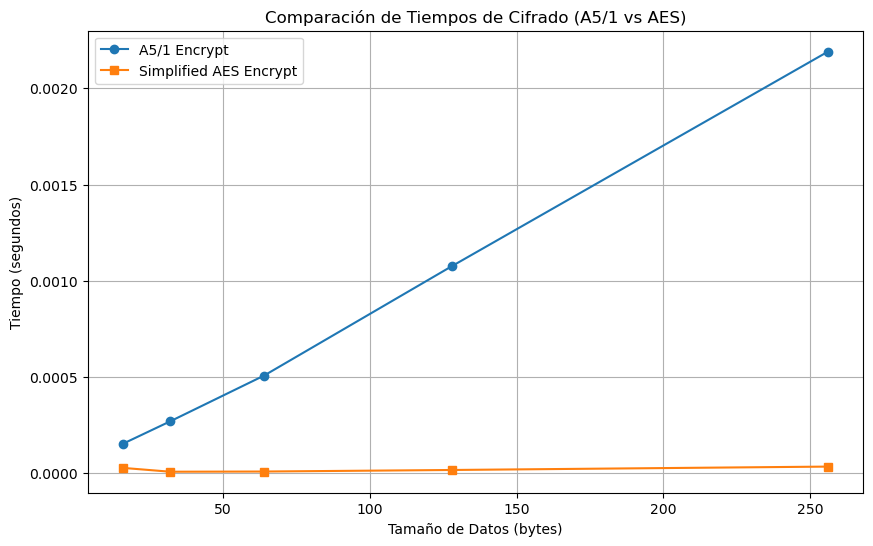

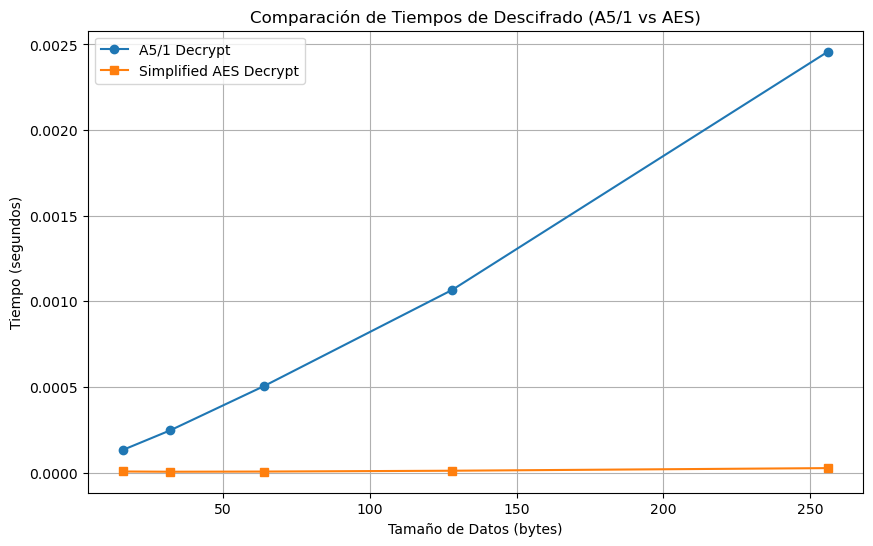

In [30]:
import os
import time
import matplotlib.pyplot as plt

# Implementación de A5/1
class LFSR:
    def __init__(self, size, taps, initial_state):
        self.size = size
        self.taps = taps
        self.state = initial_state

    def clock(self):
        feedback = 0
        for tap in self.taps:
            feedback ^= (self.state >> tap) & 1
        self.state = ((self.state << 1) & ((1 << self.size) - 1)) | feedback
        return self.state & 1

    def get_sync_bit(self, sync_position):
        return (self.state >> sync_position) & 1


class A51Cipher:
    def __init__(self, r1_state, r2_state, r3_state):
        self.R1 = LFSR(19, [18, 17, 16, 13], r1_state)
        self.R2 = LFSR(22, [21, 20], r2_state)
        self.R3 = LFSR(23, [22, 21, 20, 7], r3_state)

    def clock(self):
        majority = (self.R1.get_sync_bit(8) + self.R2.get_sync_bit(10) + self.R3.get_sync_bit(10)) >= 2
        if self.R1.get_sync_bit(8) == majority:
            self.R1.clock()
        if self.R2.get_sync_bit(10) == majority:
            self.R2.clock()
        if self.R3.get_sync_bit(10) == majority:
            self.R3.clock()

    def generate_keystream(self, length):
        keystream = []
        for _ in range(length):
            self.clock()
            keystream_bit = self.R1.state & 1 ^ self.R2.state & 1 ^ self.R3.state & 1
            keystream.append(keystream_bit)
        return bytes([sum((keystream[i + j] << (7 - j)) for j in range(8)) for i in range(0, length, 8)])

    def encrypt(self, plaintext):
        keystream = self.generate_keystream(len(plaintext) * 8)
        return bytes([p ^ k for p, k in zip(plaintext, keystream)])

    def decrypt(self, ciphertext):
        return self.encrypt(ciphertext)  # El cifrado es simétrico


# Implementación de AES Simplificado desde Cero
class SimplifiedAES:
    def __init__(self, key):
        self.key = key  # Clave de 16 bytes (128 bits)
        self.block_size = 16  # Bloque AES estándar: 128 bits

    def _pad(self, plaintext):
        # Padding para ajustar al tamaño del bloque
        padding_len = self.block_size - len(plaintext) % self.block_size
        return plaintext + bytes([padding_len] * padding_len)

    def _unpad(self, plaintext):
        # Elimina el padding del mensaje
        padding_len = plaintext[-1]
        return plaintext[:-padding_len]

    def encrypt_block(self, block):
        # Simulación simple de una operación en bloque
        return bytes([(b + k) % 256 for b, k in zip(block, self.key)])

    def decrypt_block(self, block):
        # Deshace la transformación de `encrypt_block`
        return bytes([(b - k) % 256 for b, k in zip(block, self.key)])

    def encrypt(self, plaintext):
        plaintext = self._pad(plaintext)
        blocks = [plaintext[i:i + self.block_size] for i in range(0, len(plaintext), self.block_size)]
        ciphertext = b''.join(self.encrypt_block(block) for block in blocks)
        return ciphertext

    def decrypt(self, ciphertext):
        blocks = [ciphertext[i:i + self.block_size] for i in range(0, len(ciphertext), self.block_size)]
        plaintext = b''.join(self.decrypt_block(block) for block in blocks)
        return self._unpad(plaintext)

# Medición de velocidad
def measure_speed(sensor_data_sizes):
    # Inicializar estados de A5/1
    r1_state = 0b1001000100011010001
    r2_state = 0b1100110011001100110011
    r3_state = 0b11100011100011100011100

    # Inicializar clave para SimplifiedAES
    key = os.urandom(16)  # 128 bits
    aes_cipher = SimplifiedAES(key)

    # Inicializar cifrador A5/1
    a51_cipher = A51Cipher(r1_state, r2_state, r3_state)

    # Resultados
    a51_encrypt_times, a51_decrypt_times = [], []
    aes_encrypt_times, aes_decrypt_times = [], []

    for size in sensor_data_sizes:
        # Crear datos simulados del sensor
        data = os.urandom(size)

        # A5/1: cifrado
        start_time = time.perf_counter()
        ciphertext = a51_cipher.encrypt(data)
        end_time = time.perf_counter()
        a51_encrypt_times.append(end_time - start_time)

        # A5/1: descifrado
        start_time = time.perf_counter()
        a51_cipher.decrypt(ciphertext)
        end_time = time.perf_counter()
        a51_decrypt_times.append(end_time - start_time)

        # AES: cifrado
        start_time = time.perf_counter()
        ciphertext = aes_cipher.encrypt(data)
        end_time = time.perf_counter()
        aes_encrypt_times.append(end_time - start_time)

        # AES: descifrado
        start_time = time.perf_counter()
        aes_cipher.decrypt(ciphertext)
        end_time = time.perf_counter()
        aes_decrypt_times.append(end_time - start_time)

    return a51_encrypt_times, a51_decrypt_times, aes_encrypt_times, aes_decrypt_times


# Graficar resultados en gráficos separados
def plot_encryption_comparison(sensor_data_sizes, a51_encrypt, aes_encrypt):
    plt.figure(figsize=(10, 6))
    plt.plot(sensor_data_sizes, a51_encrypt, label="A5/1 Encrypt", marker="o")
    plt.plot(sensor_data_sizes, aes_encrypt, label="Simplified AES Encrypt", marker="s")
    plt.xlabel("Tamaño de Datos (bytes)")
    plt.ylabel("Tiempo (segundos)")
    plt.title("Comparación de Tiempos de Cifrado (A5/1 vs AES)")
    plt.legend()
    plt.grid()
    plt.show()


def plot_decryption_comparison(sensor_data_sizes, a51_decrypt, aes_decrypt):
    plt.figure(figsize=(10, 6))
    plt.plot(sensor_data_sizes, a51_decrypt, label="A5/1 Decrypt", marker="o")
    plt.plot(sensor_data_sizes, aes_decrypt, label="Simplified AES Decrypt", marker="s")
    plt.xlabel("Tamaño de Datos (bytes)")
    plt.ylabel("Tiempo (segundos)")
    plt.title("Comparación de Tiempos de Descifrado (A5/1 vs AES)")
    plt.legend()
    plt.grid()
    plt.show()


# Ejecutar simulación
sensor_data_sizes = [16, 32, 64, 128, 256]  # Tamaños de datos simulados
a51_encrypt, a51_decrypt, aes_encrypt, aes_decrypt = measure_speed(sensor_data_sizes)

# Graficar resultados
plot_encryption_comparison(sensor_data_sizes, a51_encrypt, aes_encrypt)
plot_decryption_comparison(sensor_data_sizes, a51_decrypt, aes_decrypt)


